### Importing the required libaries

In [1450]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pmdarima as pm
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

### Reading the CSV file (dataset)

In [1451]:
dataset = pd.read_csv("dps_dataset.csv")
dataset.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


### Dropping the values after 2020

In [1452]:
filtered_dataset = dataset[dataset['JAHR'] <= 2020]

### Keeping the values since 2021 as test dataset

In [1453]:
test_dataset = dataset[dataset['JAHR'] > 2020]

### Visualizing historically the number of accidents per category

In [1454]:
grouped_category_data = filtered_dataset.groupby('MONATSZAHL')['WERT'].sum().reset_index()

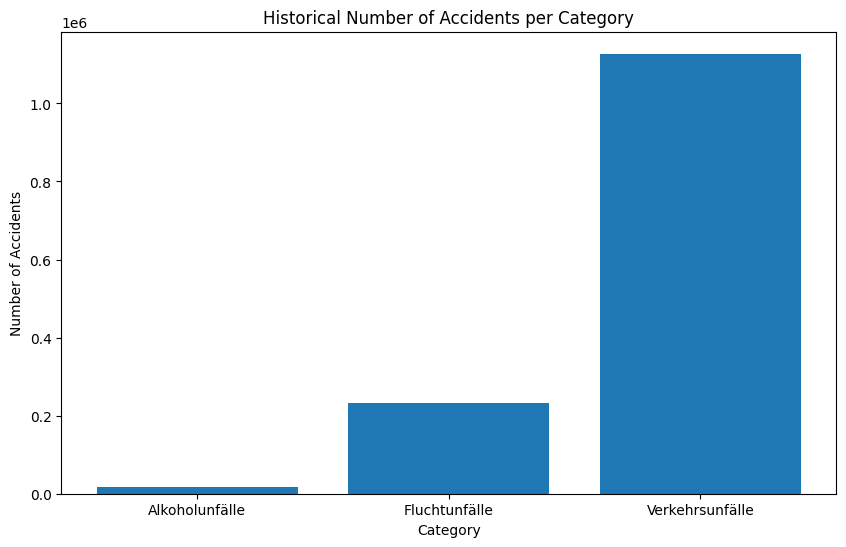

In [1455]:
plt.figure(figsize=(10, 6))
plt.bar(grouped_category_data['MONATSZAHL'], grouped_category_data['WERT'])
plt.title('Historical Number of Accidents per Category')
plt.xlabel('Category')
plt.ylabel('Number of Accidents')
plt.show()

As there is an uneven distribution of accidents for categories, we should look at each of them separately

In [1456]:
grouped_category_date_data = filtered_dataset.groupby(['MONATSZAHL', 'JAHR', 'MONAT'])['WERT'].sum().reset_index()

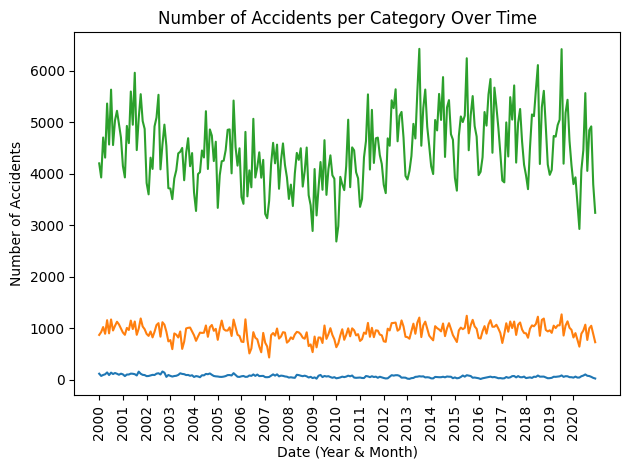

In [1457]:
for category in grouped_category_date_data['MONATSZAHL'].unique():
    category = grouped_category_date_data[grouped_category_date_data['MONATSZAHL'] == category]
    plt.plot(category['JAHR'].astype(str) + '-' + category['MONAT'].astype(str), category['WERT'], label=category)

    # Show only every 12-th tick. That is, one for each year
    n = 12
    plt.xticks(range(0, len(category['JAHR']), n), category['JAHR'][::n])
    plt.xticks(rotation=90)

plt.title('Number of Accidents per Category Over Time')
plt.xlabel('Date (Year & Month)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

We can see that there is some pattern in the data. But we will need more EDA to understand these patterns and use them to predict future values

### Some more EDA:

#### Checking for any missing values

In [1458]:
filtered_dataset.isna().sum()

MONATSZAHL                         0
AUSPRAEGUNG                        0
JAHR                               0
MONAT                              0
WERT                               0
VORJAHRESWERT                     84
VERAEND_VORMONAT_PROZENT           8
VERAEND_VORJAHRESMONAT_PROZENT    85
ZWOELF_MONATE_MITTELWERT           0
dtype: int64

**VORJAHRESWERT = previous year value**

**VERAEND_VORMONAT_PROZENT = change from previous month in percentange**

**VERAEND_VORJAHRESMONAT_PROZENT = change from previous year month in percentage**

Since we are only interested in the first 5 columns, we can drop the columns that have missing values. If we do not get a satisfactory accuracy, then we can use some imputation techniques to fill these missing values and add them to our prediction model.

##### Keeping only the first 5 columns

In [1459]:
mini_filtered_dataset = filtered_dataset.iloc[:, :5]
mini_filtered_dataset.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
36,Alkoholunfälle,insgesamt,2020,202001,28.0
37,Alkoholunfälle,insgesamt,2020,202002,40.0
38,Alkoholunfälle,insgesamt,2020,202003,27.0
39,Alkoholunfälle,insgesamt,2020,202004,26.0
40,Alkoholunfälle,insgesamt,2020,202005,40.0


We can see that the column ```MONAT``` is not exactly the month but is the concatenation of the year and month. We must convert this to contain only the month.

##### Change the Month column

In [1460]:
mini_filtered_dataset['MONAT'] = mini_filtered_dataset['MONAT'].astype(str).str[-2:]
mini_filtered_dataset.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
36,Alkoholunfälle,insgesamt,2020,01,28.0
37,Alkoholunfälle,insgesamt,2020,02,40.0
38,Alkoholunfälle,insgesamt,2020,03,27.0
39,Alkoholunfälle,insgesamt,2020,04,26.0
40,Alkoholunfälle,insgesamt,2020,05,40.0


We also observe that the indices are not ordered. So we can either index it based on year and month (since we will be working with time-series models) or just have a regular integer indexing.

##### Checking the unique values in AUSPRAEGUNG

In [1461]:
mini_filtered_dataset.AUSPRAEGUNG.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

Since there are only 3 accident sub-categories in each, we can index this too to make our time-series index unique.

##### Reset the index using Datetime indexing

In [1462]:
mini_filtered_dataset.shape

(1764, 5)

In [1463]:
mini_filtered_dataset['DATE'] = pd.to_datetime(mini_filtered_dataset['JAHR'].astype(str) + '-' + mini_filtered_dataset['MONAT'].astype(str), format='%Y-%m')
mini_filtered_dataset.set_index(['DATE'], inplace=True)

In [1464]:
mini_filtered_dataset.drop(['JAHR', 'MONAT'], axis=1, inplace=True)
mini_filtered_dataset.sort_index(inplace=True)
mini_filtered_dataset.head()

,MONATSZAHL,AUSPRAEGUNG,WERT
DATE,,,
2000-01-01,Fluchtunfälle,Verletzte und Getötete,34.0
2000-01-01,Verkehrsunfälle,mit Personenschäden,321.0
2000-01-01,Alkoholunfälle,insgesamt,78.0
2000-01-01,Fluchtunfälle,insgesamt,835.0
2000-01-01,Verkehrsunfälle,insgesamt,3448.0


In [1465]:
mini_filtered_dataset.shape

(1764, 3)

Now that the dataset looks cleaner than before, we can do some basic statistics to learn more about it.

#### Some general statistics

In [1466]:
mini_filtered_dataset.describe()

,WERT
count,1764.000000
mean,780.292517
std,1180.838117
min,0.000000
25%,38.750000
50%,360.000000
75%,813.250000
max,4763.000000


##### Splitting each category

In [1467]:
mini_filtered_dataset.MONATSZAHL.unique()

array(['Fluchtunfälle', 'Verkehrsunfälle', 'Alkoholunfälle'], dtype=object)

We have 3 categories: Alkoholunfälle (alcohol accidents), Fluchtunfälle (escape accidents), Verkehrsunfälle (traffic accidents)

In [1468]:
alcohol_accidents = mini_filtered_dataset[mini_filtered_dataset['MONATSZAHL'] == "Alkoholunfälle"]
escape_accidents = mini_filtered_dataset[mini_filtered_dataset['MONATSZAHL'] == "Fluchtunfälle"]
traffic_accidents = mini_filtered_dataset[mini_filtered_dataset['MONATSZAHL'] == "Verkehrsunfälle"]

Now that we have split the datasets into 3 categories, we can drop the MONATSZAHL column from the dataset

In [1469]:
alcohol_accidents = alcohol_accidents.drop(['MONATSZAHL'], axis=1).copy()
escape_accidents = escape_accidents.drop(['MONATSZAHL'], axis=1).copy()
traffic_accidents = traffic_accidents.drop(['MONATSZAHL'], axis=1).copy()

In [1470]:
alcohol_accidents.head()

,AUSPRAEGUNG,WERT
DATE,,
2000-01-01,insgesamt,78.0
2000-01-01,Verletzte und Getötete,37.0
2000-02-01,insgesamt,53.0
2000-02-01,Verletzte und Getötete,19.0
2000-03-01,insgesamt,73.0


We now have a clean dataset to perform time-series analysis on

#### EDA for time-series

##### Seasonal decomposition

##### Alcohol Accidents

In [1471]:
alcohol_accidents_insgesamt = alcohol_accidents[alcohol_accidents['AUSPRAEGUNG'] == 'insgesamt']

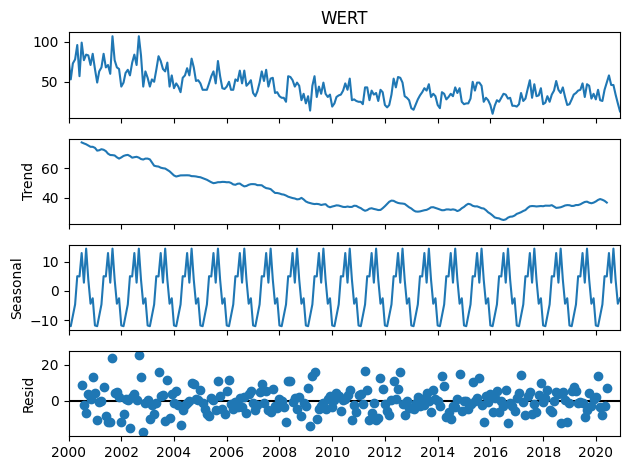

In [1472]:
decomposition = sm.tsa.seasonal_decompose(alcohol_accidents_insgesamt['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

In [1473]:
alcohol_accidents_killed = alcohol_accidents[alcohol_accidents['AUSPRAEGUNG'] == 'Verletzte und Getötete']

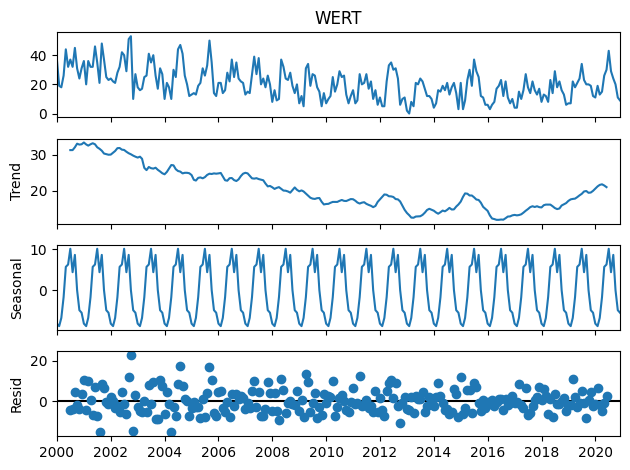

In [1474]:
decomposition = sm.tsa.seasonal_decompose(alcohol_accidents_killed['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

##### Escape Accidents

In [1475]:
escape_accidents_insgesamt = escape_accidents[escape_accidents['AUSPRAEGUNG'] == 'insgesamt']

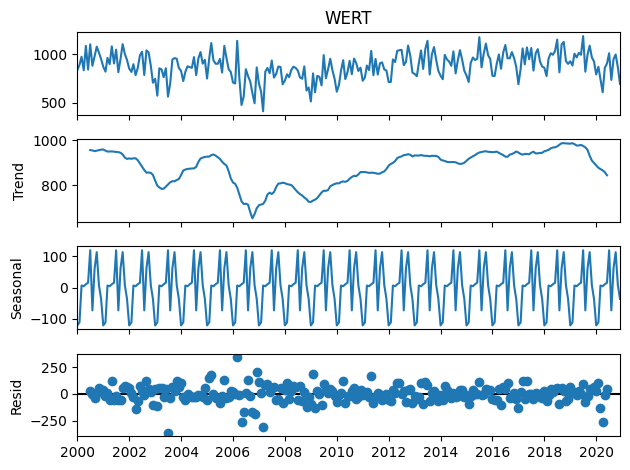

In [1476]:
decomposition = sm.tsa.seasonal_decompose(escape_accidents_insgesamt['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

In [1477]:
escape_accidents_killed = escape_accidents[escape_accidents['AUSPRAEGUNG'] == 'Verletzte und Getötete']

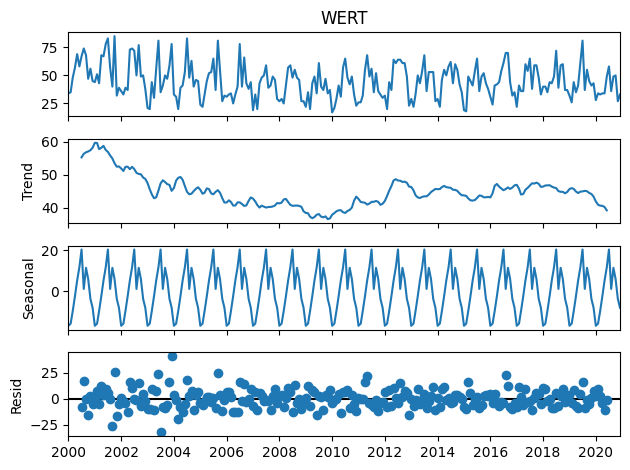

In [1478]:
decomposition = sm.tsa.seasonal_decompose(escape_accidents_killed['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

##### Traffic Accidents

In [1479]:
traffic_accidents_insgesamt = traffic_accidents[traffic_accidents['AUSPRAEGUNG'] == 'insgesamt']

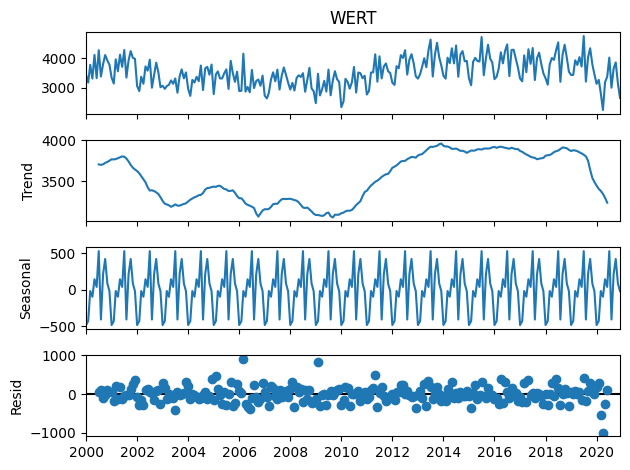

In [1480]:
decomposition = sm.tsa.seasonal_decompose(traffic_accidents_insgesamt['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

In [1481]:
traffic_accidents_killed = traffic_accidents[traffic_accidents['AUSPRAEGUNG'] == 'Verletzte und Getötete']

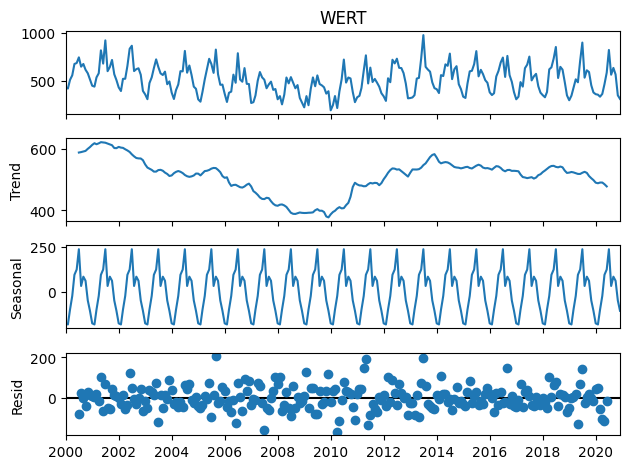

In [1482]:
decomposition = sm.tsa.seasonal_decompose(traffic_accidents_killed['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

In [1483]:
traffic_accidents_injured = traffic_accidents[traffic_accidents['AUSPRAEGUNG'] == 'mit Personenschäden']

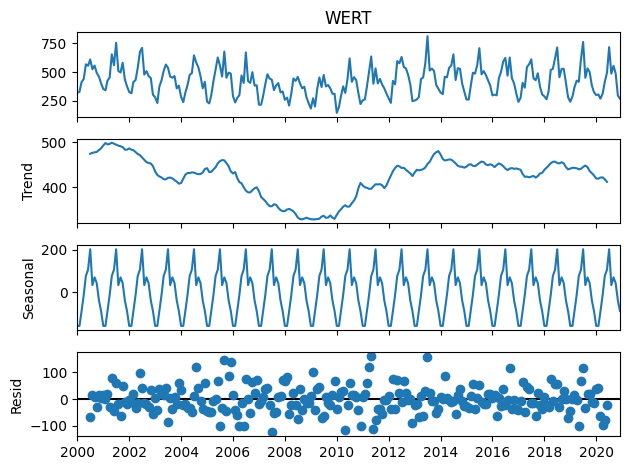

In [1484]:
decomposition = sm.tsa.seasonal_decompose(traffic_accidents_injured['WERT'].asfreq('MS'), model='additive')
fig = decomposition.plot()
plt.show()

We see that in all the above graphs, there is a clear seasonal trend. This is helpful in the stationarity or non-stationarity nature of the time series.

##### Outlier Detection

##### Alcohol Accidents

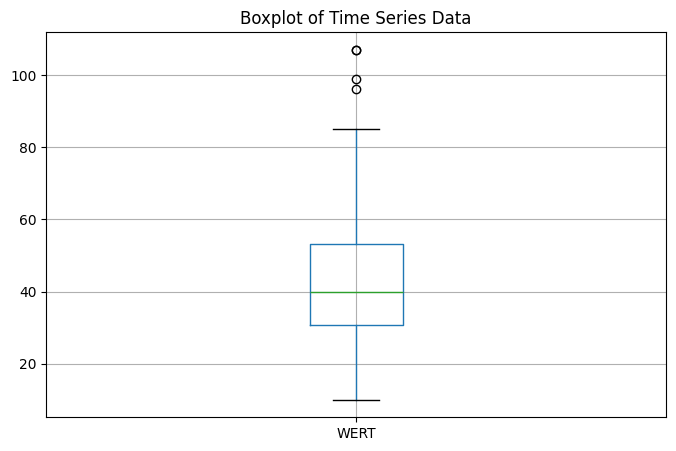

In [1485]:
plt.figure(figsize=(8, 5))
alcohol_accidents_insgesamt.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

In [1486]:
def replace_outliers_with_previous(df, column_name, z_threshold=2):
    z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    outliers_mask = abs(z_scores) > z_threshold
    df.loc[outliers_mask, column_name] = df[column_name].mean()
    return df

In [1487]:
alcohol_accidents_insgesamt = replace_outliers_with_previous(alcohol_accidents_insgesamt, 'WERT')

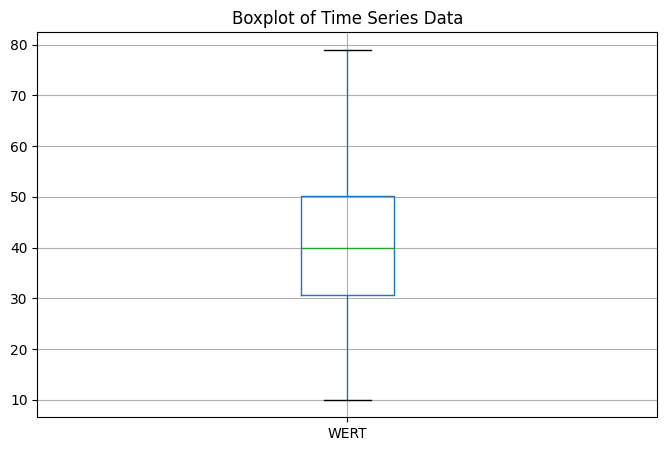

In [1488]:
plt.figure(figsize=(8, 5))
alcohol_accidents_insgesamt.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

We now see that the outlier have been imputed with mean and the boxplot shows no outliers. This imputation can be done in multiple other ways, like replacing the outlier with the value for the same month in the previous year or the mean of all the same months in previous years, or just the previous month in that year. However, I consider the overall mean for simplicity and due to time constraints.

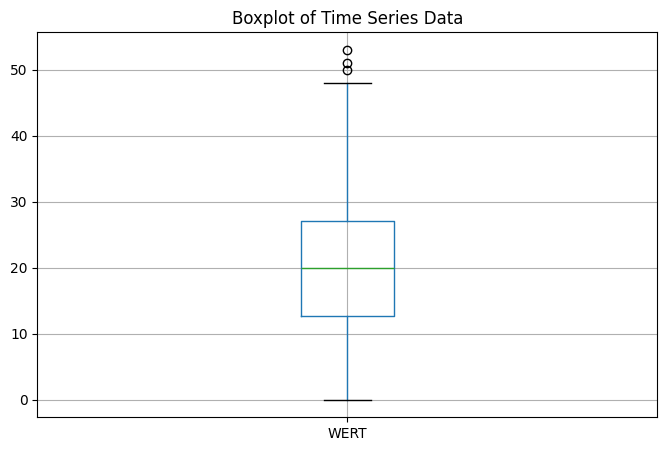

In [1489]:
plt.figure(figsize=(8, 5))
alcohol_accidents_killed.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

In [1490]:
alcohol_accidents_killed = replace_outliers_with_previous(alcohol_accidents_killed, 'WERT')

##### Escape Accidents

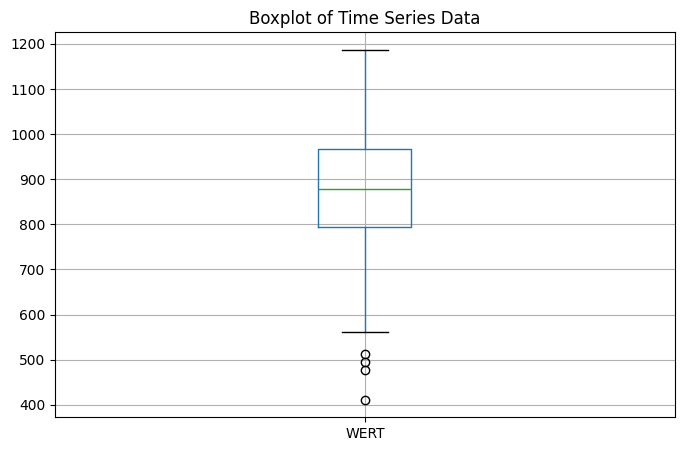

In [1491]:
plt.figure(figsize=(8, 5))
escape_accidents_insgesamt.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

In [1492]:
escape_accidents_insgesamt = replace_outliers_with_previous(escape_accidents_insgesamt, 'WERT')

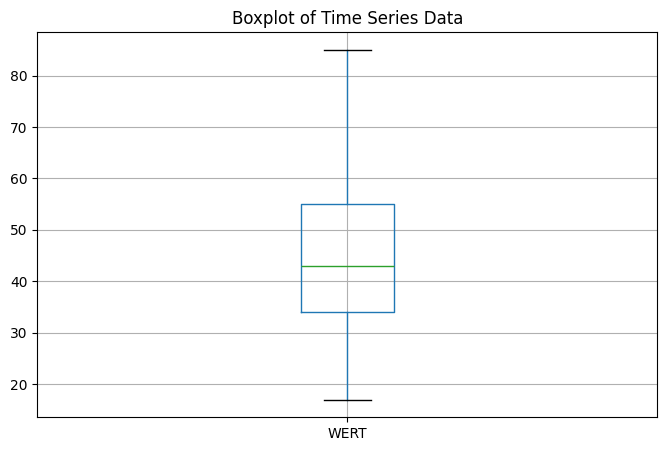

In [1493]:
plt.figure(figsize=(8, 5))
escape_accidents_killed.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

In [1494]:
escape_accidents_killed = replace_outliers_with_previous(escape_accidents_killed, 'WERT')

##### Traffic Accidents

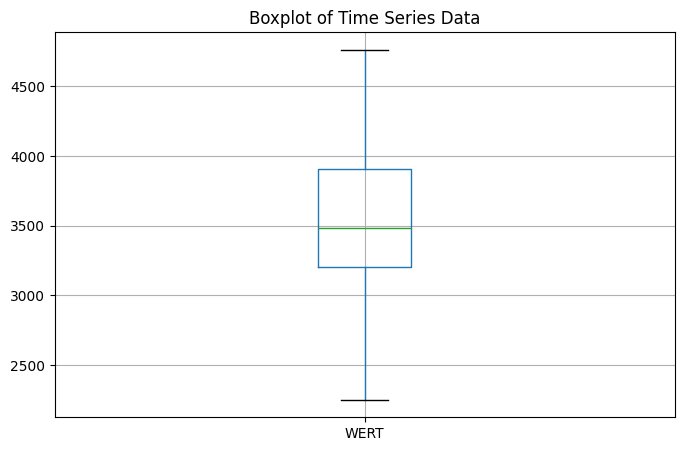

In [1495]:
plt.figure(figsize=(8, 5))
traffic_accidents_insgesamt.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

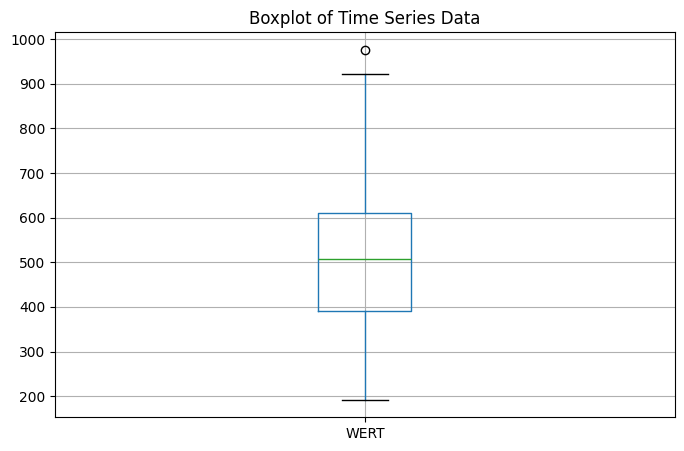

In [1496]:
plt.figure(figsize=(8, 5))
traffic_accidents_killed.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

In [1497]:
traffic_accidents_killed = replace_outliers_with_previous(traffic_accidents_killed, 'WERT')

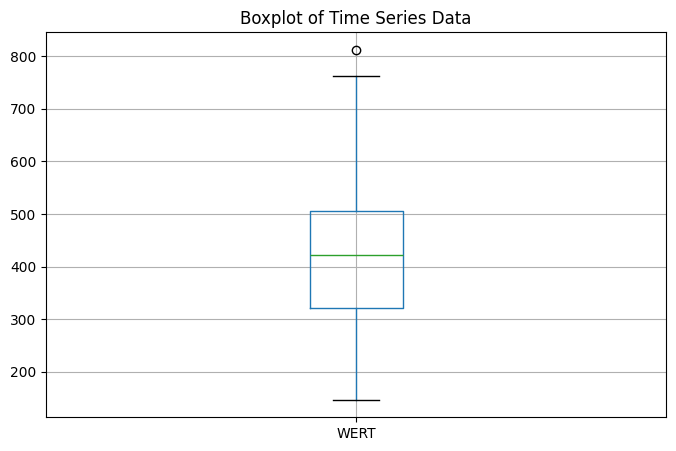

In [1498]:
plt.figure(figsize=(8, 5))
traffic_accidents_injured.boxplot(column='WERT')
plt.title('Boxplot of Time Series Data')
plt.show()

In [1499]:
traffic_accidents_injured = replace_outliers_with_previous(traffic_accidents_injured, 'WERT')

#### Autocorrelation and Partial Autocorrelation

In [1500]:
datasets = {
        'alcohol_accidents_insgesamt': alcohol_accidents_insgesamt,
        'alcohol_accidents_killed': alcohol_accidents_killed,
        'escape_accidents_insgesamt': escape_accidents_insgesamt,
        'escape_accidents_killed': escape_accidents_killed,
        'traffic_accidents_insgesamt': traffic_accidents_insgesamt,
        'traffic_accidents_killed': traffic_accidents_killed,
        'traffic_accidents_injured': traffic_accidents_injured
    }

In [1501]:
def correlation_plots(datasets, column):
    for dataset in datasets:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        sm.graphics.tsa.plot_acf(datasets[dataset][column], lags=20, ax=ax[0])
        sm.graphics.tsa.plot_pacf(datasets[dataset][column], lags=20, ax=ax[1])
        plt.show()

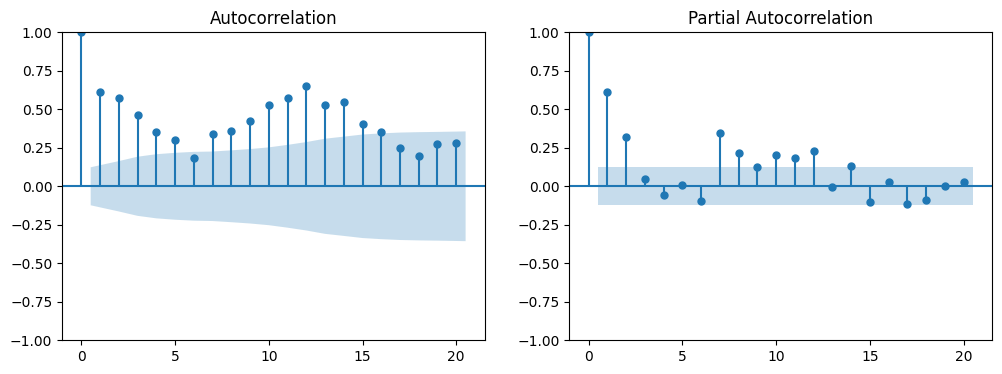

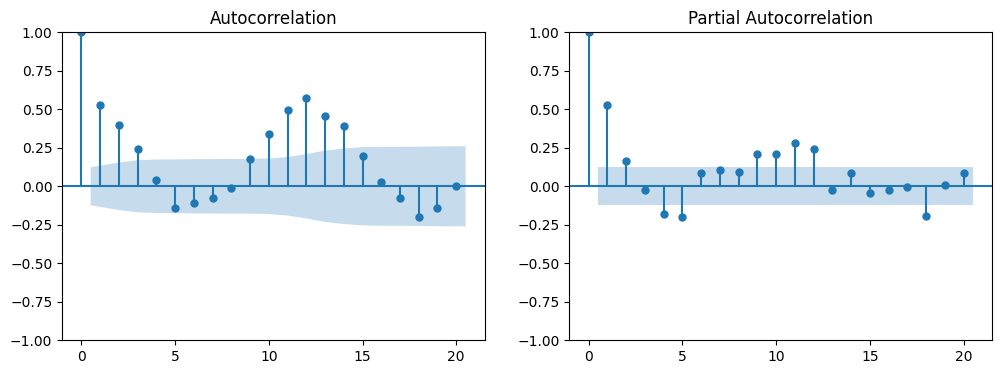

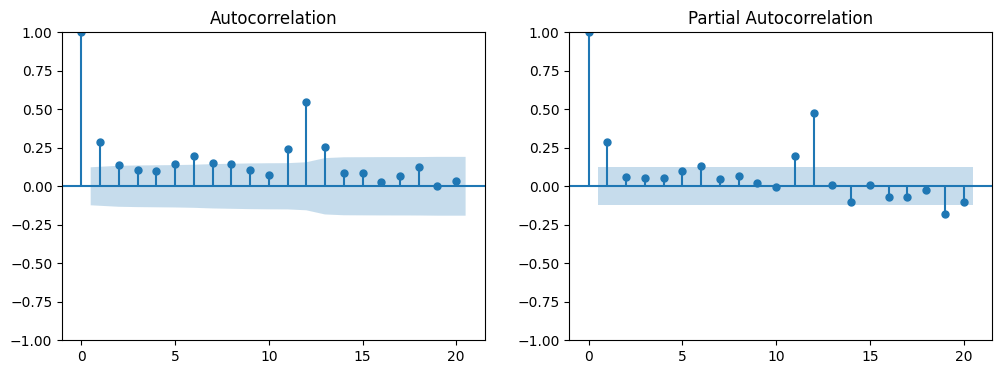

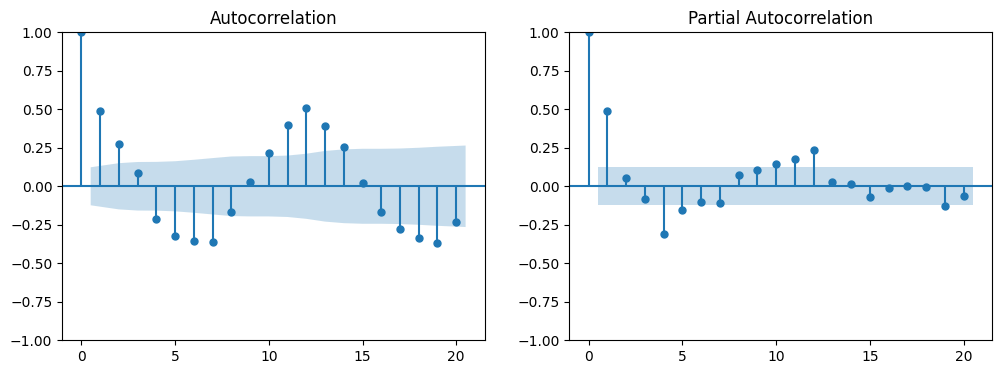

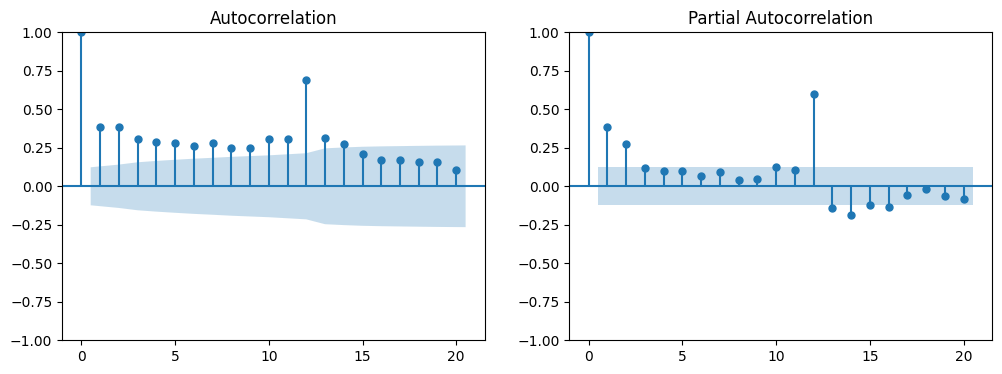

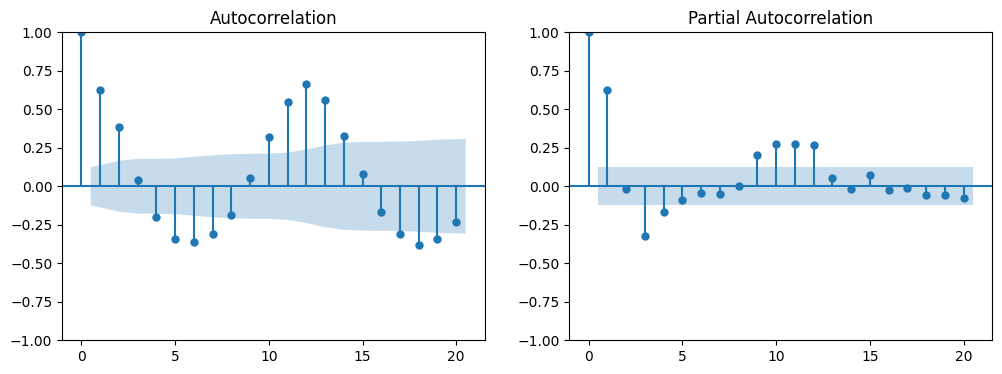

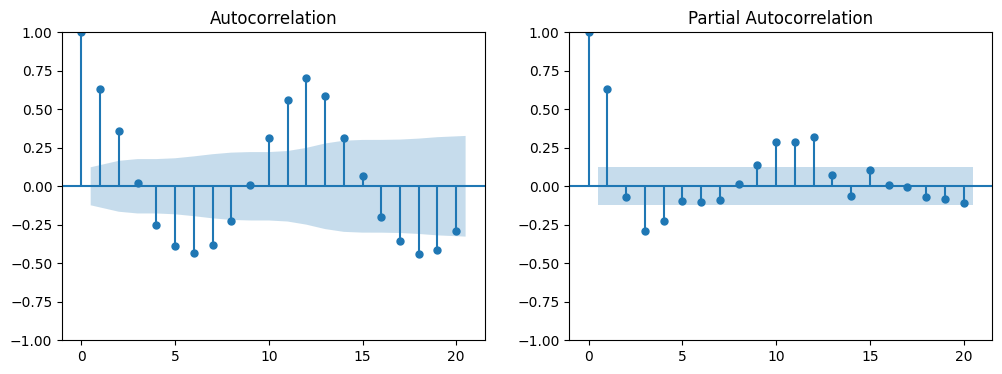

In [1502]:
correlation_plots(datasets, 'WERT')

#### Stationarity Test

In [1503]:
def checkStationarity(datasets, column):
    for dataset in datasets:
        print("Stationarity test results for " + dataset + " dataset:")
        result_adf = sm.tsa.adfuller(datasets[dataset][column], maxlag=20)
        print(f'ADF Statistic: {result_adf[0]}')
        print(f'p-value: {result_adf[1]}')
        print('\n')

In [1504]:
checkStationarity(datasets, 'WERT')

Stationarity test results for alcohol_accidents_insgesamt dataset:
ADF Statistic: -1.340142342746768
p-value: 0.6106130186762757


Stationarity test results for alcohol_accidents_killed dataset:
ADF Statistic: -1.9518953996325565
p-value: 0.30805510951801435


Stationarity test results for escape_accidents_insgesamt dataset:
ADF Statistic: -2.7010456521157584
p-value: 0.07385750027720658


Stationarity test results for escape_accidents_killed dataset:
ADF Statistic: -3.3962949237808595
p-value: 0.0110858277231566


Stationarity test results for traffic_accidents_insgesamt dataset:
ADF Statistic: -1.9397399915601519
p-value: 0.31360317683740424


Stationarity test results for traffic_accidents_killed dataset:
ADF Statistic: -1.9803194829902204
p-value: 0.29526842376955503


Stationarity test results for traffic_accidents_injured dataset:
ADF Statistic: -1.8681962315524296
p-value: 0.3471672800117377




p-value in all the above cases is greater than 0.05 (our assumed significance level), so we fail to reject the null hypothesis that the time series is stationary.

#### Differencing the time series

In [1505]:
for dataset in datasets:
    datasets[dataset] = datasets[dataset].copy()
    datasets[dataset]['WERT_D1'] = datasets[dataset]['WERT'].diff().fillna(0.0)

In [1506]:
checkStationarity(datasets, 'WERT_D1')

Stationarity test results for alcohol_accidents_insgesamt dataset:
ADF Statistic: -5.4581782893087345
p-value: 2.553694046939336e-06


Stationarity test results for alcohol_accidents_killed dataset:
ADF Statistic: -5.862405050619798
p-value: 3.3862373792816505e-07


Stationarity test results for escape_accidents_insgesamt dataset:
ADF Statistic: -13.883251595879777
p-value: 6.155794733572105e-26


Stationarity test results for escape_accidents_killed dataset:
ADF Statistic: -10.801634572580705
p-value: 2.010849196237004e-19


Stationarity test results for traffic_accidents_insgesamt dataset:
ADF Statistic: -2.864494952195932
p-value: 0.04963527721590711


Stationarity test results for traffic_accidents_killed dataset:
ADF Statistic: -11.642679613763038
p-value: 2.128289488098905e-21


Stationarity test results for traffic_accidents_injured dataset:
ADF Statistic: -12.324517332313485
p-value: 6.63560276669481e-23




We see that the p-value is less than 0.05 for all cases and we can use the ARIMA model now.

#### ARIMA Model

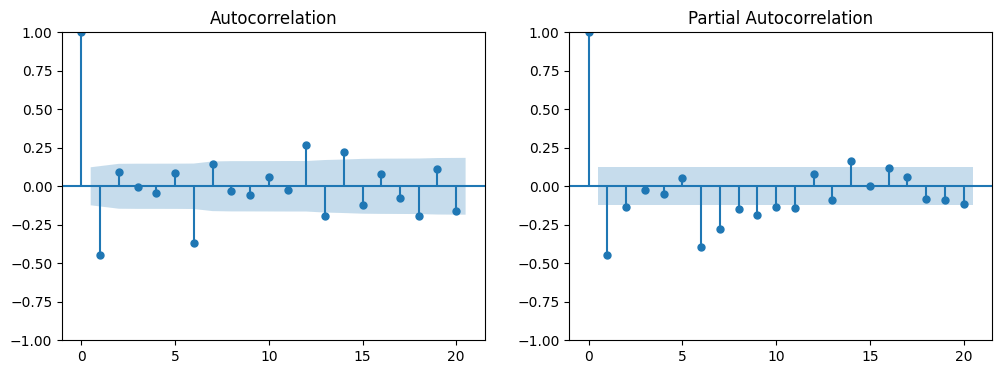

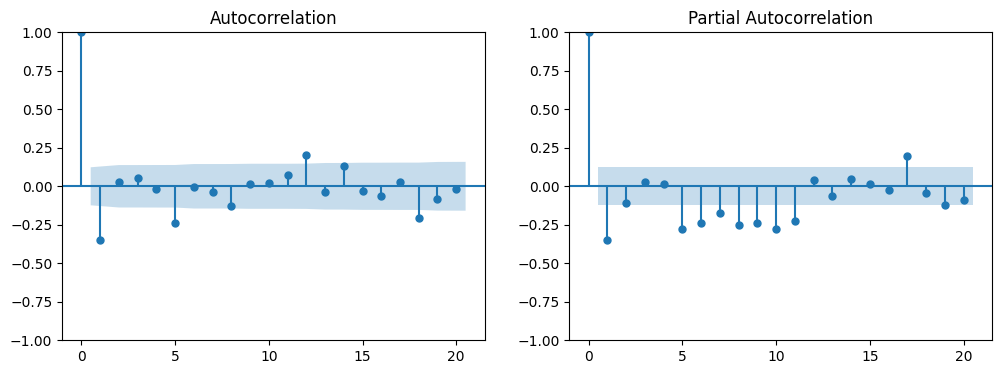

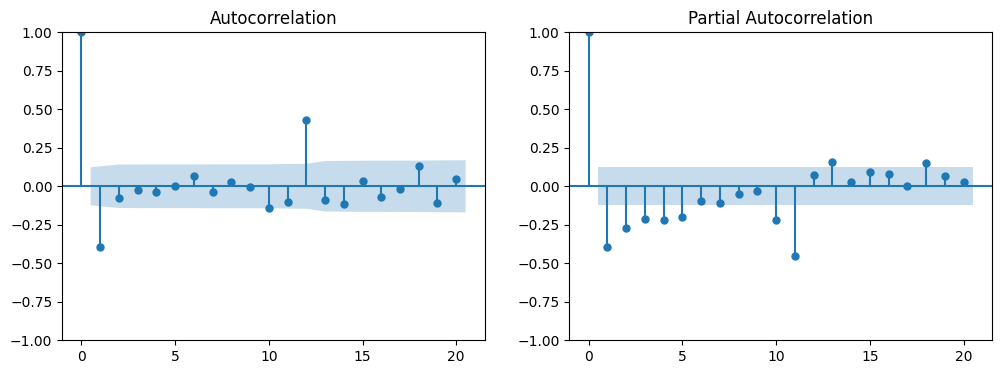

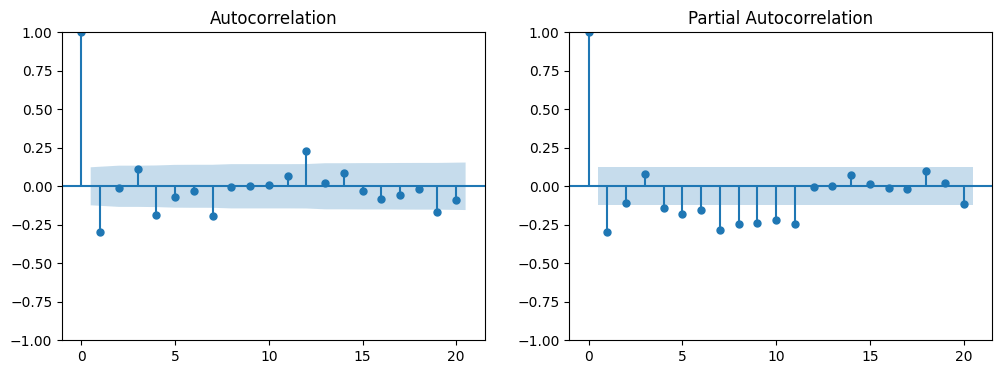

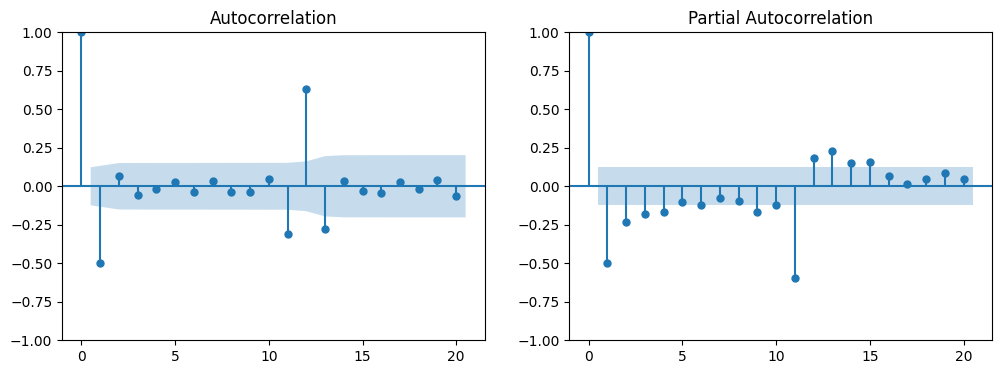

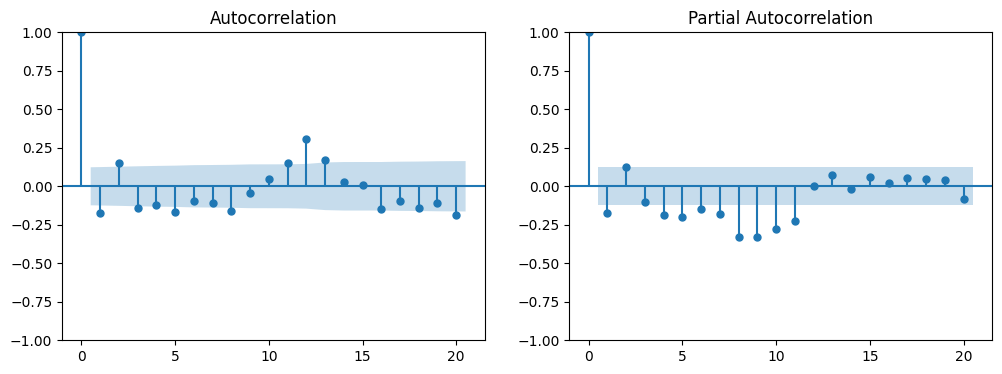

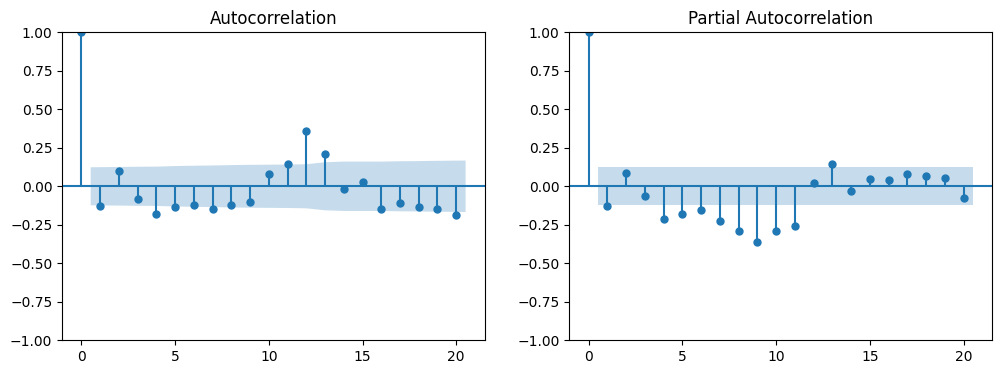

In [1507]:
correlation_plots(datasets, 'WERT_D1')

From the above ACF and PACF graphs, we can make a list of certain p and q values that will likely work well for the ARIMA model.

##### Alcohol Accidents (Insgesamt)

In [1508]:
alcohol_insgesamt_test = test_dataset[(test_dataset['MONATSZAHL'] == 'Alkoholunfälle') & (test_dataset['AUSPRAEGUNG'] == 'insgesamt')].iloc[:, :5]

In [1509]:
alcohol_insgesamt_test.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN


In [1510]:
alcohol_insgesamt_test = alcohol_insgesamt_test[alcohol_insgesamt_test['JAHR'] <= 2021]
alcohol_insgesamt_test.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
24,Alkoholunfälle,insgesamt,2021,202101,16.0
25,Alkoholunfälle,insgesamt,2021,202102,14.0
26,Alkoholunfälle,insgesamt,2021,202103,24.0
27,Alkoholunfälle,insgesamt,2021,202104,16.0
28,Alkoholunfälle,insgesamt,2021,202105,24.0


In [1511]:
alcohol_insgesamt_test_vals = alcohol_insgesamt_test['WERT'].tolist()

In [1512]:
history = [x for x in alcohol_accidents_insgesamt['WERT']]
predictions = list()

for t in range(len(alcohol_insgesamt_test_vals)):
    model = ARIMA(history, order=(2, 1, 3))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output[0])
    obs = alcohol_insgesamt_test_vals[t]
    history.append(obs)

error = mean_squared_error(alcohol_insgesamt_test_vals, predictions)
print('Forecast Accuracy \nMSE: %3f' % error)

/Users/prahithamovva/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/prahithamovva/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/prahithamovva/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/prahithamovva/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast Accuracy 
MSE: 66.837108


In [1513]:
seasonal_order = (0, 0, 0, 0)
seasonal_frequency = 12
model = pm.auto_arima([x for x in alcohol_accidents_insgesamt['WERT']], seasonal=False)
print(f'Selected ARIMA parameters: {model.order}')

Selected ARIMA parameters: (2, 1, 1)


In [1514]:
history = [x for x in alcohol_accidents_insgesamt['WERT']]
predictions = list()

for t in range(len(alcohol_insgesamt_test_vals)):
    model = SARIMAX(history, order=(0, 1, 2), seasonal_order=(1, 0, 1, 12), supress_warnings=True)
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output[0])
    obs = alcohol_insgesamt_test_vals[t]
    history.append(obs)

error = mean_squared_error(alcohol_insgesamt_test_vals, predictions)
print('Forecast Accuracy \nMSE: %3f' % error)

/Users/prahithamovva/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['supress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78049D+00    |proj g|=  2.48530D-01

At iterate    5    f=  3.66816D+00    |proj g|=  1.44428D-01

At iterate   10    f=  3.64362D+00    |proj g|=  1.24868D-02

At iterate   15    f=  3.64034D+00    |proj g|=  7.31591D-04

At iterate   20    f=  3.64032D+00    |proj g|=  3.49645D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   2.023D-07   3.640D+00
  F =   3.6403238330191496     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  3.64292D+00    |proj g|=  1.41579D-02

At iterate   15    f=  3.64088D+00    |proj g|=  1.36032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   8.285D-06   3.641D+00
  F =   3.6408502595056285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77870D+00    |proj g|=  2.52064D-01


 This problem is unconstrained.



At iterate    5    f=  3.67037D+00    |proj g|=  6.81288D-02

At iterate   10    f=  3.64716D+00    |proj g|=  1.06250D-02

At iterate   15    f=  3.64584D+00    |proj g|=  9.24462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.025D-06   3.646D+00
  F =   3.6458306597968182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78003D+00    |proj g|=  2.58555D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  3.64437D+00    |proj g|=  1.11406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   7.936D-07   3.644D+00
  F =   3.6443632332239178     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77603D+00    |proj g|=  2.48737D-01

At iterate    5    f=  3.67480D+00    |proj g|=  1.57044D-01


 This problem is unconstrained.



At iterate   10    f=  3.64838D+00    |proj g|=  1.22506D-02

At iterate   15    f=  3.64619D+00    |proj g|=  1.75287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   2.572D-06   3.646D+00
  F =   3.6461741104813115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77374D+00    |proj g|=  2.46857D-01

At iterate    5    f=  3.67131D+00    |proj g|=  1.37954D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  3.64627D+00    |proj g|=  1.55190D-03

At iterate   20    f=  3.64623D+00    |proj g|=  1.36264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   4.049D-07   3.646D+00
  F =   3.6462259441556211     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77834D+00    |proj g|=  2.31942D-01

At iterate    5    f=  3.66812D+00    |proj g|=  5.61092D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.64870D+00    |proj g|=  1.24925D-02

At iterate   15    f=  3.64692D+00    |proj g|=  1.73987D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   8.530D-06   3.647D+00
  F =   3.6468853195127893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77850D+00    |proj g|=  2.36293D-01

At iterate    5    f=  3.66714D+00    |proj g|=  6.00893D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  3.64626D+00    |proj g|=  8.68691D-03

At iterate   15    f=  3.64548D+00    |proj g|=  7.89227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.003D-06   3.645D+00
  F =   3.6454748077729269     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77740D+00    |proj g|=  2.32312D-01


 This problem is unconstrained.



At iterate    5    f=  3.67420D+00    |proj g|=  7.64587D-02

At iterate   10    f=  3.64843D+00    |proj g|=  4.71954D-03

At iterate   15    f=  3.64708D+00    |proj g|=  1.06958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   5.573D-06   3.647D+00
  F =   3.6470821224209393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77469D+00    |proj g|=  2.29346D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  3.64749D+00    |proj g|=  8.22327D-03

At iterate   15    f=  3.64586D+00    |proj g|=  1.15850D-03

At iterate   20    f=  3.64581D+00    |proj g|=  7.51657D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   7.517D-06   3.646D+00
  F =   3.6458142231586059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77331D+00    |proj g|=  2.27257D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  3.64419D+00    |proj g|=  1.65061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   5.508D-06   3.644D+00
  F =   3.6441824545078920     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Forecast Accuracy 
MSE: 96.506973
